<a href="https://colab.research.google.com/github/CIS6930-NLP/final_project/blob/main/Transformer_model_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### For practice: Empathetic Response Generation on EmpatheticDialogues

Paper for Empatheticdialogue Transformer model
https://arxiv.org/pdf/2204.11320v1.pdf
 

<figure>
<center>
<img src='https://drive.google.com/uc?id=1iXkrghQAzHF58ctIMWBMwpEk-L0EYlFi' />
<figcaption>Transformer Architecture</figcaption></center>
</figure>


#### Import libraries

In [1]:
import tensorflow as tf
import re
import nltk
import numpy as np
import math
import time
import pandas as pd
from google.colab import drive
from tensorflow.keras import layers
import tensorflow_datasets as tfds
# import keras_nlp
import matplotlib.pyplot as plt

# try:
#     %tensorflow_version 2.x
# except Exception:
#     pass
# import tensorflow as tf

print(tf.__version__)

2.11.0


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#check GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Data preprocessing

#### Load data

In [9]:
train_file = "/content/drive/MyDrive/code/Updated Data/train.csv"
val_file = "/content/drive/MyDrive/code/Updated Data/valid.csv"
test_file = "/content/drive/MyDrive/code/Updated Data/test.csv"
def data_loading(filepath): 
  data = pd.read_csv(filepath, encoding = 'utf-8')
  data = data.drop('conv_id', axis = 1)
  data = data.drop('utterance_idx', axis = 1)
  data = data.drop('speaker_idx', axis = 1)
  data = data.drop('selfeval', axis = 1)
  data = data.drop('tags', axis = 1)
  data = data.dropna()
  return data

train_data = data_loading(train_file)
val_data = data_loading(val_file)
test_data = data_loading(test_file)
train_data.head()

,Unnamed: 0,context,prompt,utterance
0,0,sentimental,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...
1,1,sentimental,I remember going to the fireworks with my best...,Was this a friend you were in love with_comma_...
2,2,sentimental,I remember going to the fireworks with my best...,This was a best friend. I miss her.
3,3,sentimental,I remember going to the fireworks with my best...,Where has she gone?
4,4,sentimental,I remember going to the fireworks with my best...,We no longer talk.


In [10]:
#emotion classifier
def data_loading2(filepath): 
    data = pd.read_csv(filepath, encoding = 'utf-8')
    data = data.drop('conv_id', axis = 1)
    data = data.drop('utterance_idx', axis = 1)
    data = data.drop('speaker_idx', axis = 1)
    data = data.drop('selfeval', axis = 1)
    data = data.drop('tags', axis = 1)
    data = data.drop('utterance', axis = 1)

    data = data.dropna()
    return data

train_data2 = data_loading(train_file)
val_data2 = data_loading(val_file)
test_data2 = data_loading(test_file)
train_data2.head()

,Unnamed: 0,context,prompt,utterance
0,0,sentimental,I remember going to the fireworks with my best...,I remember going to see the fireworks with my ...
1,1,sentimental,I remember going to the fireworks with my best...,Was this a friend you were in love with_comma_...
2,2,sentimental,I remember going to the fireworks with my best...,This was a best friend. I miss her.
3,3,sentimental,I remember going to the fireworks with my best...,Where has she gone?
4,4,sentimental,I remember going to the fireworks with my best...,We no longer talk.


In [11]:
#Grouping emotions 
emotions = {}
emotions['excited'] = emotions['surprised'] = emotions['joyful'] = "excited"
emotions['afraid'] = emotions['terrified'] = emotions['anxious']= emotions['apprehensive']='afraid'
emotions['disgusted'] = emotions['embarrassed']= emotions['guilty'] = emotions['ashamed'] ="disgusted"
emotions['angry'] = emotions ['annoyed'] = emotions['jealous'] =emotions[ 'furious' ] = "annoyed"
emotions['faithful'] = emotions ['trusting']=emotions ['grateful']= emotions['caring'] = emotions['hopeful'] = "grateful"
emotions['sad'] = emotions['disappointed'] = emotions['devastated']= emotions ['lonely']=emotions['nostalgic']=emotions['sentimental'] = "disappointed"
emotions['proud']= emotions['impressed']= emotions['content'] = "impressed"
emotions['anticipating']=emotions[ 'prepared']=emotions ['confident'] = "prepared"
dicttt=emotions

In [12]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

In [13]:
train_context = train_data['context']
train_question = train_data['prompt']
train_answer = train_data['utterance']


val_context = val_data['context']
val_question = val_data['prompt']
val_answer = val_data['utterance']

test_context = test_data['context']
test_question = test_data['prompt']
test_answer = test_data['utterance']
# print(len(train_context))
# print(len(train_question))
# print(len(train_answer))

  # Maximum number of samples to preprocess
MAX_SAMPLES = 50000

train_context = [preprocess_sentence(emotions[sentence]) for sentence in train_context]
train_questions = [preprocess_sentence(sentence) for sentence in train_question]
train_answers = [preprocess_sentence(sentence) for sentence in train_answer]

val_context = [preprocess_sentence(emotions[sentence]) for sentence in val_context]
val_questions = [preprocess_sentence(sentence) for sentence in val_question]
val_answers = [preprocess_sentence(sentence) for sentence in val_answer]

test_context = [preprocess_sentence(emotions[sentence]) for sentence in test_context]
test_questions = [preprocess_sentence(sentence) for sentence in test_question]
test_answers = [preprocess_sentence(sentence) for sentence in test_answer]

In [14]:
print('Sample context: {}'.format(train_context[20]))
print('Sample question: {}'.format(train_questions[20]))
print('Sample answer: {}'.format(train_answers[20]))

Sample context: grateful
Sample question: i have always been loyal to my wife .
Sample answer: what do you mean it has not been easy ? how close have you come to cheating ?


In [15]:
### emotion_classifier
train_context2 = train_data2['context']
train_question2 = train_data2['prompt']

val_context2 = val_data2['context']
val_question2 = val_data2['prompt']


test_context2 = test_data2['context']
test_question2 = test_data2['prompt']

train_context2 = [preprocess_sentence(emotions[sentence]) for sentence in train_context]
train_questions2 = [preprocess_sentence(sentence) for sentence in train_question]


val_context2 = [preprocess_sentence(emotions[sentence]) for sentence in val_context]
val_questions2 = [preprocess_sentence(sentence) for sentence in val_question]


test_context2 = [preprocess_sentence(emotions[sentence]) for sentence in test_context]
test_questions2 = [preprocess_sentence(sentence) for sentence in test_question]


#### Hyperparameters 

In [16]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


In [50]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 100

#### Tokenization


In [18]:
# Build tokenizer using tfds for both questions and answers
# changed "features" to "deprecated"

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train_questions + train_answers + train_context , target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [19]:
print(train_questions[20])
print('Tokenized sample question: {}'.format(tokenizer.encode(train_questions[20])))
print(VOCAB_SIZE)
print(tokenizer.decode([25]))
print(START_TOKEN)
print(END_TOKEN)

i have always been loyal to my wife .
Tokenized sample question: [1, 20, 98, 59, 1639, 5, 4, 744, 3]
8174
when 
[8172]
[8173]


#### Create Input/output 

In [21]:

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs, context):
  tokenized_inputs, tokenized_outputs, tokenized_context = [], [], []
  
  for (sentence1, sentence2, emotion) in zip(inputs, outputs, context):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    emotion = tokenizer.encode(emotion)
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
      tokenized_context.append(emotion)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs, tokenized_context


questions, answers, context = tokenize_and_filter(train_questions, train_answers, train_context)

In [22]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))
print(questions[20])
print(questions[20][0], questions[20][-1])
print(len(questions[20]))

Vocab size: 8174
Number of samples: 76184
[8172    6 2420  122  419   13    1   30  123   23   74   67  863  105
    1   93   57    1   37   18  263   62    3 8173    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
8172 0
40


In [23]:
## create dataset

In [24]:

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input1': questions,
        'input2': context,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
print(dataset,'\n')
dataset_iter_0 = iter(dataset).next()


inp1  = dataset_iter_0[0]['input1'].numpy()[2]
inp2 = dataset_iter_0[0]['input2'].numpy()[2]
dec_inp = dataset_iter_0[0]['dec_inputs'].numpy()[2]
out  = dataset_iter_0[1]['outputs'].numpy()[2]

print('question: inputs[2] = ', inp1)
print('context: inputs[2] = ', inp2)
print('ans: dec_inputs[2] = ', dec_inp)
print('ans: outputs[2] = ', out)

<PrefetchDataset element_spec=({'input1': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'input2': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})> 

question: inputs[2] =  [8172    1  193    9 3737    5   76    5    6  137  565 5500   49   15
  500    5 5242 7948    4  985    2    1    9   72   15  226  119 3737
    8    1   37   18  890   11    5  736    3 8173    0    0]
context: inputs[2] =  [48]
ans: dec_inputs[2] =  [8172   11   39  422    2    1    9   67 3306  142   25    1  133   49
   53   46   22 8173    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
ans: outputs[2] =  [  11   39  422    2    1    9   67 3306  142   25    1  133   49   53
   46   22 8173    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [26]:
## Attention

def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [27]:
print(dataset)

<PrefetchDataset element_spec=({'input1': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'input2': TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

###### Masking

In [29]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [30]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [31]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [32]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
# class PositionalEncoding(layers.Layer): #inheriting from the Layers class

#   def __init__(self, position, d_model):
#     super(PositionalEncoding, self).__init__()
#     self.pos_encoding = self.positional_encoding(position, d_model)

#   def get_angles(self, position, i, d_model):
#     angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
#     return position * angles

#   def positional_encoding(self, position, d_model):
#     angle_rads = self.get_angles(
#         position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
#         i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
#         d_model=d_model)
#     # apply sin to even index in the array
#     sines = tf.math.sin(angle_rads[:, 0::2])
#     # apply cos to odd index in the array
#     cosines = tf.math.cos(angle_rads[:, 1::2])

#     pos_encoding = tf.concat([sines, cosines], axis=-1)
#     pos_encoding = pos_encoding[tf.newaxis, ...]
#     return tf.cast(pos_encoding, tf.float32)

#   def call(self, inputs):
#     return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [54]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
  
  def get_config(self):

        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
            
        })
        return config

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [ ]:
# def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
#   inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   attention = MultiHeadAttention(
#       d_model, num_heads, name="attention")({
#           'query': inputs,
#           'key': inputs,
#           'value': inputs,
#           'mask': padding_mask
#       })
#   attention = tf.keras.layers.Dropout(rate=dropout)(attention)
#   attention = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(inputs + attention)

#   outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
#   outputs = tf.keras.layers.Dense(units=d_model)(outputs)
#   outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#   outputs = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention + outputs)

#   return tf.keras.Model(
#       inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [34]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  add_attention = tf.keras.layers.add([inputs,attention])
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([attention,outputs])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# def encoder(vocab_size,
#             num_layers,
#             units,
#             d_model,
#             num_heads,
#             dropout,
#             name="encoder"):
#   input1 = tf.keras.Input(shape=(None,), name="input1")
#   input2 = tf.keras.Input(shape=(None,), name="imput2")
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

#   embedding1 = tf.keras.layers.Embedding(vocab_size, d_model)(input1)
#   embedding1 *= tf.math.sqrt(tf.cast(d_model, tf.float32))

#   embedding2 = tf.keras.layers.Embedding(vocab_size, d_model)(input2)
#   embedding2 *= tf.math.sqrt(tf.cast(d_model, tf.float32))

#   embeddings = outputs = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(embedding1 + embedding2)

#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

#   outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#   for i in range(num_layers):
#     outputs = encoder_layer(
#         units=units,
#         d_model=d_model,
#         num_heads=num_heads,
#         dropout=dropout,
#         name="encoder_layer_{}".format(i),
#     )([outputs, padding_mask])

#   return tf.keras.Model(
#       inputs=[input1,input2, padding_mask], outputs=outputs, name=name)

In [35]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  input1 = tf.keras.Input(shape=(None,), name="input1")
  input2 = tf.keras.Input(shape=(None,), name="input2")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embedding1 = tf.keras.layers.Embedding(vocab_size, d_model)(input1)
  embedding1 *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  
  embedding2 = tf.keras.layers.Embedding(vocab_size, d_model)(input2)
  embedding2 *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)

  embeddings = outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(embedding1 + embedding2)
  embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[input1,input2, padding_mask], outputs=outputs, name=name)

### Decoder

In [ ]:
# def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
#   inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
#   look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

#   attention1 = MultiHeadAttention(
#       d_model, num_heads, name="attention_1")(inputs={
#           'query': inputs,
#           'key': inputs,
#           'value': inputs,
#           'mask': look_ahead_mask
#       })
#   attention1 = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention1 + inputs)

#   attention2 = MultiHeadAttention(
#       d_model, num_heads, name="attention_2")(inputs={
#           'query': attention1,
#           'key': enc_outputs,
#           'value': enc_outputs,
#           'mask': padding_mask
#       })
#   attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
#   attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

#   outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
#   outputs = tf.keras.layers.Dense(units=d_model)(outputs)
#   outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
#   outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

#   return tf.keras.Model(
#       inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
#       outputs=outputs,
#       name=name)

In [36]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  add_attention = tf.keras.layers.add([attention1,inputs])    
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  add_attention = tf.keras.layers.add([attention2,attention1])
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  add_attention = tf.keras.layers.add([outputs,attention2])
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
# def decoder(vocab_size,
#             num_layers,
#             units,
#             d_model,
#             num_heads,
#             dropout,
#             name='decoder'):
#   inputs = tf.keras.Input(shape=(None,), name='inputs')
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
#   look_ahead_mask = tf.keras.Input(
#       shape=(1, None, None), name='look_ahead_mask')
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
#   embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
#   embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
#   embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

#   outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

#   for i in range(num_layers):
#     outputs = decoder_layer(
#         units=units,
#         d_model=d_model,
#         num_heads=num_heads,
#         dropout=dropout,
#         name='decoder_layer_{}'.format(i),
#     )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

#   return tf.keras.Model(
#       inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
#       outputs=outputs,
#       name=name)

In [37]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [38]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  input1 = tf.keras.Input(shape=(None,), name="input1")
  input2 = tf.keras.Input(shape=(None,), name="input2")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(input1)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(input1)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[input1, input2, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[input1, input2, dec_inputs], outputs=outputs, name=name)

In [39]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  input1 = tf.keras.Input(shape=(None,), name="input1")
  input2 = tf.keras.Input(shape=(None,), name="input2")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(input1)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(input1)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[input1,input2, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[input1,input2, dec_inputs], outputs=outputs, name=name)

In [40]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

# tf.keras.utils.plot_model(
#     sample_transformer, to_file='transformer.png', show_shapes=True)

## Train Model

In [41]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [42]:
#Loss function
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

In [ ]:
#custom learning rate
# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

#   def __init__(self, d_model, warmup_steps=4000):
#     super(CustomSchedule, self).__init__()

#     self.d_model = d_model
#     self.d_model = tf.cast(self.d_model, tf.float32)
#     self.warmup_steps = warmup_steps

#   def __call__(self, step):
#     arg1 = tf.math.rsqrt(step)
#     arg2 = step * (self.warmup_steps**-1.5)

#     return tf.math.rsqrt(tf.cast(self.d_model, tf.float32)) * tf.math.minimum(arg1, arg2)

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = tf.constant(d_model,dtype=tf.float32)
    self.warmup_steps = warmup_steps
    
  def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

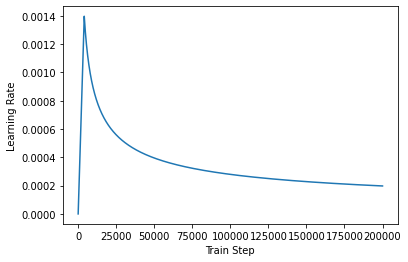

In [44]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [46]:
print(sample_learning_rate)

### Compile

In [47]:
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0014, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
  model = transformer(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT)

  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['input1[0][0]']                 
                                                                                        

In [48]:
# checkpoint_path = "/content/drive/MyDrive/code/transformer_ckpt/"

# ckpt = tf.train.Checkpoint(transformer=model,
#                            optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print("Latest checkpoint restored!")


In [49]:
def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [ ]:
# model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy', metrics=[accuracy])

In [ ]:
# EPOCHS = 10
# for epoch in range(EPOCHS):
#     print("Start of epoch {}".format(epoch+1))
#     start = time.time()

#     train_loss.reset_states()
#     train_accuracy.reset_states()

#     for (batch, (enc_inputs, y_true)) in enumerate(dataset):
#         dec_inputs = y_true[:, :-1]
#         dec_outputs_real = y_true[:, 1:]

#         with tf.GradientTape() as tape:
#             predictions = transformer(enc_inputs, dec_inputs, True)
#             loss = loss_function(dec_outputs_real, predictions)

#         gradients = tape.gradient(loss, transformer.trainable_variables,)
#         optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

#         train_loss(loss)
#         train_accuracy(dec_outputs_real, predictions)

#         print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
#                 epoch+1, batch, train_loss.result(), train_accuracy.result()))

#         if batch % 2 == 0:
#             print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
#                 epoch+1, batch, train_loss.result(), train_accuracy.result()))
    

#     ckpt_save_path = ckpt_manager.save()
#     print("Saving checkpont for epoch {} at {}".format(epoch+1, ckpt_save_path))
#     print("time taken for 1 epoch: {} secs\n".format(time.time() - start))

# model.fit(dataset, epochs=EPOCHS)
# ckpt_save_path = ckpt_manager.save()
# print("Saving checkpont for epoch {} at {}".format(epoch+1, ckpt_save_path))
# print("time taken for 1 epoch: {} secs\n".format(time.time() - start))

In [51]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
1191/1191 [==============================] - 172s 120ms/step - loss: 1.8490 - accuracy: 0.0920
Epoch 2/100
1191/1191 [==============================] - 83s 69ms/step - loss: 1.6009 - accuracy: 0.1131
Epoch 3/100
1191/1191 [==============================] - 86s 72ms/step - loss: 1.5305 - accuracy: 0.1189
Epoch 4/100
1191/1191 [==============================] - 87s 73ms/step - loss: 1.4845 - accuracy: 0.1228
Epoch 5/100
1191/1191 [==============================] - 78s 66ms/step - loss: 1.4510 - accuracy: 0.1256
Epoch 6/100
1191/1191 [==============================] - 75s 63ms/step - loss: 1.4239 - accuracy: 0.1277
Epoch 7/100
1191/1191 [==============================] - 82s 69ms/step - loss: 1.4032 - accuracy: 0.1292
Epoch 8/100
1191/1191 [==============================] - 90s 76ms/step - loss: 1.3852 - accuracy: 0.1305
Epoch 9/100
1191/1191 [==============================] - 90s 75ms/step - loss: 1.3689 - accuracy: 0.1319
Epoch 10/100
1191/1191 [=============================

In [81]:
# save model and load
model.save('/content/drive/MyDrive/code/sample_tf_base_model') 

tf_base_model = tf.keras.models.load_model('/content/drive/MyDrive/code/sample_tf_base_model')

# Check its architecture
# tf_base_model.summary()

TypeError: ignored

In [53]:
model.save('/content/drive/MyDrive/code/sample_tf_base_model.h5') 

# tf_base_model_h5 = tf.keras.models.load_model('/content/drive/MyDrive/code/tf_base_model.h5')

# Show the model architecture
# tf_base_model_h5.summary()

AttributeError: ignored

In [56]:
def evaluate(sentence, context):
  sentence = preprocess_sentence(str(sentence))
  context = preprocess_sentence(str(context))

  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(str(sentence)) + END_TOKEN, axis=0)
  context = tokenizer.encode(str(context))

  # input = tf.concat([sentence, context], -1)  
  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, context, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence, context):
  prediction = evaluate(sentence,context)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Context: {}'.format(context))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [57]:
output = predict('Where have you been?', 'grateful')

Input: Where have you been?
Context: grateful
Output: i am so thankful for everything in my life .


In [58]:
print(evaluate("Hello how are you?", "grateful"))

tf.Tensor(
[8172    1   14  254    5  221  118    2   45   21   58  207   96 1102
  125  646   29], shape=(17,), dtype=int32)


In [ ]:
# def translate(sentence, context):
#     output = evaluate(sentence, context).numpy()

#     predicted_sentence = tokenizer.decode(
#         [i for i in output if i < VOCAB_SIZE-2]
#     )

#     print("Input: {}".format(sentence))
#     print("Output: {}".format(predicted_sentence))

In [ ]:
# translate("Hello how are you", "grateful")

In [59]:
# feed the model with its previous output - need to predic context
# need to make changes to the context 
sentence = 'i have always been loyal to my wife.'

## need an emotional classifier as well as a response prefix...
context = 'grateful'
for _ in range(5):
  sentence = predict(sentence, context)
  print('')

Input: i have always been loyal to my wife.
Context: grateful
Output: i have been married for years . i have been married for years . i have been married for about years now .

Input: i have been married for years . i have been married for years . i have been married for about years now .
Context: grateful
Output: i have been married for ten years now . i have been married for years

Input: i have been married for ten years now . i have been married for years
Context: grateful
Output: i have been married for years . i have been married for years .

Input: i have been married for years . i have been married for years .
Context: grateful
Output: i have been married for years . i have been married for years .

Input: i have been married for years . i have been married for years .
Context: grateful
Output: i have been married for years . i have been married for years .



### Emotion classifier Model

In [60]:
train_df2 = pd.DataFrame({'label' : train_context2,
                'utterance' : train_questions2}, 
                                columns=['label','utterance'])
val_df2 = pd.DataFrame({'label' : val_context2,
                'utterance' : val_questions2}, 
                                columns=['label','utterance'])
test_df2 = pd.DataFrame({'label' : test_context2,
                'utterance' : test_questions2}, 
                                columns=['label','utterance'])

In [61]:
train_df2['label'].value_counts()

disappointed    15519
grateful        11596
annoyed         11074
afraid          10100
excited         10083
disgusted        9935
impressed        8042
prepared         7818
Name: label, dtype: int64

In [62]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

X_train2 = train_df2['utterance']
y_train2 = train_df2['label']


# X_val2 = val_df2['utterance']
# y_val2 = val_df2['label']

# X_test2 = test_df2['utterance']
# y_test2 = test_df2['label']

In [63]:
# Cv 
cv = CountVectorizer()
X = cv.fit_transform(X_train2)
# print(X_test_cv.shape)
# print(X_val_cv.shape)


# print(y_test.shape)
# print(y_train.shape)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_train2, test_size=0.33, random_state=42)

In [73]:
from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression()
model_logit.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [74]:
model_logit.score(X_test, y_test)

0.8560267857142857

In [67]:
def predict_emotion(text,model):
    myvect = cv.transform([text]).toarray()
    prediction = model.predict(myvect)
#     pred_percentage = dict(zip(model.classes_,model.predict_proba(vect)[0]))
    print(prediction)
    return prediction

In [68]:
emotion_output = str(predict_emotion("I am the best",model_logit))

['grateful']


In [86]:
# Save Model
# model_logit.save('/content/drive/MyDrive/code/em_clf_model') 
# model_logit.save('/content/drive/MyDrive/code/em_clf_model.h5') 
import pickle

filepath= '/content/drive/MyDrive/code/em_clf_mode.pkl'
with open('/content/drive/MyDrive/code/em_clf_model_pickle', 'wb') as f:
  pickle.dump(model_logit,f)

In [70]:
def predict(sentence):
  context = str(predict_emotion(sentence,model_logit))
  prediction = evaluate(sentence,context)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
  
  print('Context: {}'.format(context))
  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [71]:
# need to make changes to the context 
sentence = 'i have always been loyal to my wife.'

## need an emotional classifier as well as a response prefix...
# context = 'grateful'
for _ in range(5):
  sentence = predict(sentence)
  print('')

['grateful']
Context: ['grateful']
Input: i have always been loyal to my wife.
Output: i have been married for years . i have been married for years . i have been married for about years now .

['grateful']
Context: ['grateful']
Input: i have been married for years . i have been married for years . i have been married for about years now .
Output: i have been married for ten years now . i have been married for years

['excited']
Context: ['excited']
Input: i have been married for ten years now . i have been married for years
Output: i have been married for ten years now . i am so happy for him comma i have a relationship with him

['grateful']
Context: ['grateful']
Input: i have been married for ten years now . i am so happy for him comma i have a relationship with him
Output: i have been married for years . i have been married for years . i have been married for years and have been married for years

['grateful']
Context: ['grateful']
Input: i have been married for years . i have been